In [1]:
import os
import time

import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.display import clear_output

import mlflow
import mlflow.sklearn
import mlflow.lightgbm

import shap
import optuna

from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score

from src import CustomObjective, CustomScorer
from src import DataCollector, FeatureExtractor, DataLoader
from src import ModelTuner

In [2]:
def get_dataframe(model, X, y, threshold=0.5):
    def _set_label(y_true, y_pred):
        if y_true == 1. and y_pred == 1.: return "TP"
        elif y_true == 0. and y_pred == 0.: return "TN"
        elif y_true == 1. and y_pred == 0.: return "FN"
        elif y_true == 0. and y_pred == 1.: return "FP"
    y_prob = 1. / (1. + np.exp(-model.predict(X, raw_score=True)))
    df = pd.DataFrame({
        "y_true":y,
        "y_pred":np.array(y_prob > threshold, dtype=np.float16),
        "y_prob":y_prob,
    })
    df["label"] = df.apply(lambda x: _set_label(x["y_true"], x["y_pred"]), axis=1)
    return df

def suggest_lgbm(trial: optuna.trial.Trial):
    obj_alpha = trial.suggest_float("obj_alpha", 0.05, 0.99)
    obj_gamma = trial.suggest_float("obj_gamma", 0.0, 5.0)
    obj_beta  = trial.suggest_float("obj_beta", 0.7, 1.0)     
    return {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),  
        "n_estimators": trial.suggest_int("n_estimators", 10, 200),                 
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),    
        "num_leaves": trial.suggest_int("num_leaves", 16, 512),
        "max_depth": trial.suggest_int("max_depth", -1, 16),                  
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1, 2, 5]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1e2, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-8, 1e-1, log=True),
        "objective": CustomObjective(alpha=obj_alpha, gamma=obj_gamma, beta=obj_beta),
    }

category = "food"

config = {
    "experiment-title":"title-001",
    "collector":{
        "category":category,
        "id_vars":["CERT_NO", "SRNG_RSLT_YR"],
        "na_code":"<NA>"
    },
    "extractor":{
        "category":category,
        "encode_info":[
        (["ITEM_TYPE_VL"], "ITEM_TYPE_VL", "SRNG_RSLT_CD", ["CERT_NO", "SRNG_RSLT_YR"]),
        (["CTGRY_NM"], "CTGRY_NM", "SRNG_RSLT_CD", ["CERT_NO", "SRNG_RSLT_YR"]),
        (["CERT_NO"], "CERT_NO", "SRNG_RSLT_CD", ["LCPMT_NO"])
    ]},
    "loader":{
        "category":category,
        "cat_features":[
            "EVL_SCL_VL", "DUTY_PHS_NO", "DUTY_SE_NM", "TPBIZ_CD"
        ],
        "bin_features":[
            "DRV_PRVYR_NEW", "DRV_PRVYR_SLS_YN", "DRV_FAIL_YN_1YR", "DRV_FAIL_YN_2YR","MAIN_SFTPV_VLTN_YN"
        ],
        "con_features":[
            "DRV_FRST_CERT_DT", "DRV_CERT_BGNG_DT","DRV_CERT_END_DT", "PRVYR_SLS_AMT", "EVL_SCR_PRVYR", "HACCP_SCR_PRVYR",
            "DRV_P_ITEM_TYPE_VL", "DRV_Var_ITEM_TYPE_VL","DRV_H_ITEM_TYPE_VL","DRV_PMI_ITEM_TYPE_VL","DRV_ODDS_ITEM_TYPE_VL","DRV_IG_ITEM_TYPE_VL",
            # "DRV_BP_ITEM_TYPE_VL","DRV_BVar_ITEM_TYPE_VL","DRV_BH_ITEM_TYPE_VL","DRV_BPMI_ITEM_TYPE_VL","DRV_BODDS_ITEM_TYPE_VL","DRV_BIG_ITEM_TYPE_VL",
            "DRV_P_CTGRY_NM","DRV_Var_CTGRY_NM","DRV_H_CTGRY_NM","DRV_PMI_CTGRY_NM","DRV_ODDS_CTGRY_NM","DRV_IG_CTGRY_NM",
            # "DRV_BP_CTGRY_NM","DRV_BVar_CTGRY_NM","DRV_BH_CTGRY_NM","DRV_BPMI_CTGRY_NM","DRV_BODDS_CTGRY_NM","DRV_BIG_CTGRY_NM",
        ],
        "sampler":"smote",
        "sampling_strategy":"auto",
        "test_size":0.3,
        "pos_label":"부적합",
        "random_state":42,
    },
    "trainer":{
        "category":category,
        "model":LGBMClassifier(verbose=-1)
    },
    "tuner": {
        "scorer":CustomScorer(recall_score),
        "greater_is_better":True,
        "cv":5,
        "n_jobs":1,
        "verbose":-1,
    }
}

In [3]:
# utilities
def _safe_log_artifacts(path: str, artifact_subdir: str = None):
    p = Path(path)
    if p.exists():
        mlflow.log_artifacts(p.as_posix(), artifact_path=artifact_subdir)

def _log_score_dict(prefix: str, score):
    if isinstance(score, dict):
        mlflow.log_metrics({f"{prefix}_{k}": float(v) for k, v in score.items()})
    else:
        mlflow.log_metric(f"{prefix}_score", float(score))

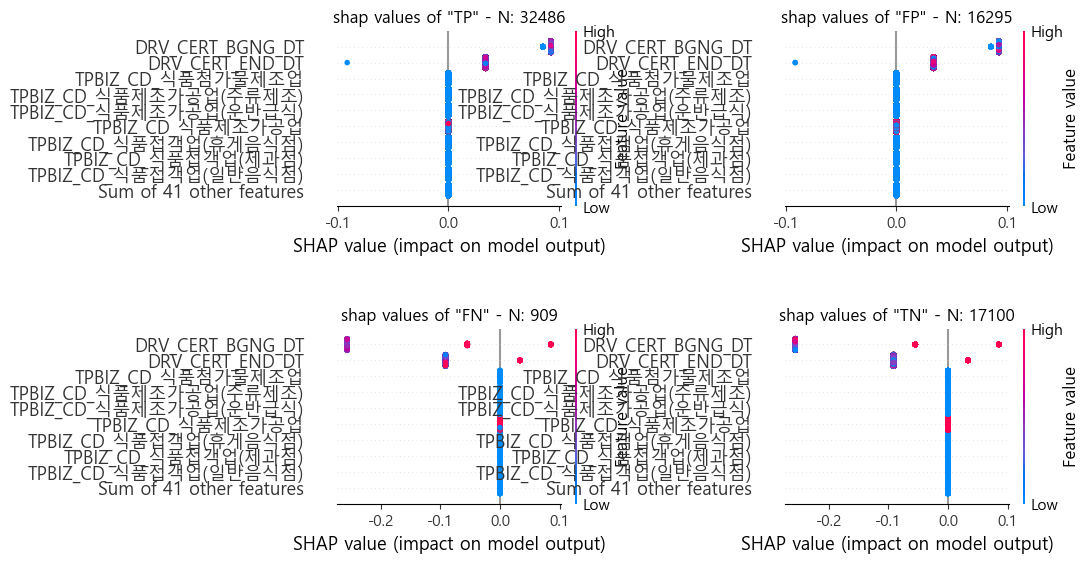

In [ ]:
# Tracking/Experiment 설정

mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment(config.get("experiment", "HACCP-RISK-MODEL"))
# mlflow.set_registry_uri("sqlite:///mlflow.db")  # ← (선택) Model Registry 쓸 때 DB 지정


with mlflow.start_run(run_name=f"E2E-{time.strftime('%Y%m%d-%H%M%S')}"):
    
    mlflow.set_tags({
        "project": config.get("project", "my_project"),  # ← 프로젝트 식별
        "env": os.getenv("ENV", "local"),  # ← 환경 식별(local/dev/prod)
    })

    with mlflow.start_run(run_name="DataCollector", nested=True, tags={"stage": "data_collect"}):
        mlflow.log_params({"collector": str(config.get("collector", {}))})
        collector = DataCollector(**config["collector"])
        # collector.remove_dataframe("F")
        # collector.remove_dataframe("L")
        collector.run()
        
        out_dir = config.get("collector", {}).get("output_dir")
        if out_dir:
            _safe_log_artifacts(out_dir, artifact_subdir="data/raw")


    with mlflow.start_run(run_name="FeatureExtractor", nested=True, tags={"stage": "feature"}):
        mlflow.log_params({"extractor": str(config.get("extractor", {}))})
        extractor = FeatureExtractor(**config["extractor"])
        extractor.run()

        feat_dir = config.get("extractor", {}).get("output_dir")
        if feat_dir:
            _safe_log_artifacts(feat_dir, artifact_subdir="data/feature")


    with mlflow.start_run(run_name="DataLoader", nested=True, tags={"stage": "load"}):
        mlflow.log_params({"loader": str(config.get("loader", {}))})
        loader = DataLoader(**config["loader"])
        X_train, X_test, y_train, y_test = loader.load()


    with mlflow.start_run(run_name="ModelTuningAndTraining", nested=True, tags={"stage": "train/tune"}):
        tune_iters = 3
        mlflow.lightgbm.autolog(log_input_examples=False, log_model_signatures=True, log_datasets=False)

        mlflow.log_params({
            "trainer": str(config.get("trainer", {})),
            "tuner": str(config.get("tuner", {})),
            "tune_iters": tune_iters
        })

        tuner = ModelTuner(**config["trainer"], **config["tuner"])
        tuning_result = tuner.tune_optuna(
            suggest_fn=suggest_lgbm, X=X_train, y=y_train, n_iters=tune_iters
        )

        model = tuning_result["trained_model"]
        train_score = tuner.score_info(model, X_train, y_train)
        test_score = tuner.score_info(model, X_test, y_test)

        _log_score_dict("train", train_score)
        _log_score_dict("test", test_score)

        try:
            import lightgbm as lgb
            if isinstance(getattr(model, "booster_", model), (lgb.Booster,)):
                mlflow.lightgbm.log_model(model, artifact_path="model")
            else:
                mlflow.sklearn.log_model(model, artifact_path="model")
        except Exception:
            mlflow.sklearn.log_model(model, artifact_path="model")


    with mlflow.start_run(run_name="ModelExplainer", nested=True, tags={"stage": "explain"}):
        mlflow.log_param("explainer", "shap.Explainer")
        explainer = shap.Explainer(model)

        is_train = False
        df_train = get_dataframe(model, X_train, y_train)
        df_test = get_dataframe(model, X_test, y_test)
        df = df_train if is_train else df_test

        clear_output()
        plt.figure(figsize=(10, 8))

        shap_values_all = explainer(X_train if is_train else X_test)
        
        for i, lab in enumerate(["TP", "FP", "FN", "TN"]):
            index = df[df.label == lab].index
            shap_values = shap.Explanation(
                values=shap_values_all.values[index, :],
                base_values=shap_values_all.base_values[index],
                data=shap_values_all.data[index, :],
                feature_names=shap_values_all.feature_names
            )
            plt.subplot(2, 2, i + 1)
            shap.plots.beeswarm(
                shap_values=shap_values,
                max_display=10,
                show=False
            )
            plt.title(f'shap values of "{lab}" - N: {index.shape[0]}')


        plt.subplots_adjust(left=0.07, right=0.98, bottom=0.07, top=0.93, wspace=0.6, hspace=0.7)
        
        out_img_dir = Path("./reports/fig"); out_img_dir.mkdir(parents=True, exist_ok=True)
        out_img_path = out_img_dir / "shap_beeswarm_grid.png"
        plt.savefig(out_img_path.as_posix(), dpi=150, bbox_inches="tight")
        _safe_log_artifacts(out_img_dir.as_posix(), artifact_subdir="fig")
    

mlflow.end_run()


In [5]:
!mlflow ui --port 5000

^C
